In [1]:
import cv2
import glob
# get background subtractor
sub_type = 'MOG2' # 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True)
    # backSub.setShadowThreshold(0.75)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

In [2]:
import numpy as np


def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask



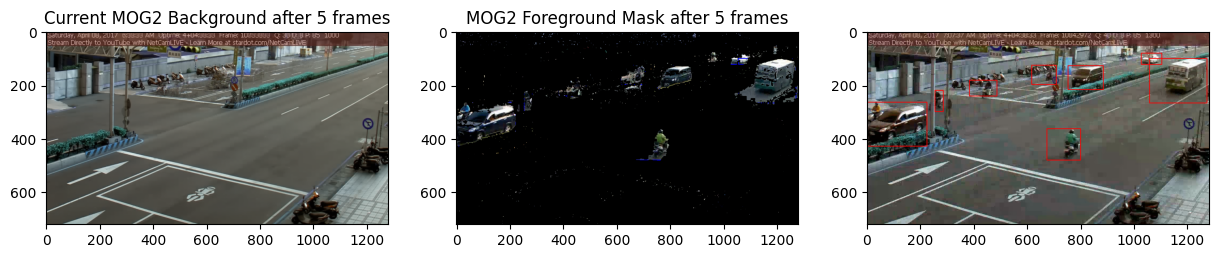

In [5]:
from matplotlib import pyplot as plt
folder_path='/mnt/data_hdd3/zby/frame_pic/taipei_test'
query_inputs = glob.glob(folder_path + "/*")
frame_count=0
for img_path in query_inputs[:100]:
    image = cv2.imread(img_path)
    # update the background model and obtain foreground mask
    frame_count=frame_count+1
    fg_mask = backSub.apply(image)
    # 将掩码应用于原始图像以获得彩色前景
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    # fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    # fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
    # 寻找轮廓
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # 绘制轮廓及边界框
    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    sh=image

    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
background=backSub.getBackgroundImage()
# for img_path in query_inputs[:100]:
#     image = cv2.imread(img_path)
#     diff = cv2.absdiff(background, image)
#     diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
#     _, fg_mask = cv2.threshold(diff, 70, 255, cv2.THRESH_BINARY)
#     color_foreground = cv2.bitwise_and(image, image, mask=fg_mask)
# display
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(cv2.cvtColor(color_foreground, cv2.COLOR_BGR2RGB)) 
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")
ax[2].imshow(sh)

In [ ]:
def get_mask(frame1, frame2, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            kernel - (NxN) array for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """

    frame_diff = cv2.subtract(frame2, frame1)

    # blur the frame difference
    frame_diff = cv2.medianBlur(frame_diff, 3)
    
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV, 11, 3)

    mask = cv2.medianBlur(mask, 3)

    # morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask


# compute motion mask
kernel = np.array((9,9), dtype=np.uint8)
mask = get_mask(img1, img2, kernel)

In [1]:
import os
import cv2
import numpy as np
import time
import glob

def calculate_histogram(image, bins=256):
    """计算图像的颜色直方图"""
    histogram = cv2.calcHist([image], [0], None, [bins], [0, 256])
    return cv2.normalize(histogram, histogram).flatten()

def compare_histograms(hist1, hist2, method=cv2.HISTCMP_CHISQR):
    """比较两个直方图"""
    hist1 = hist1.astype('float32')
    hist2 = hist2.astype('float32')
    return cv2.compareHist(hist1, hist2, method)

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask=fg_mask
        return motion_mask

    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask,image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    color_foreground=cv2.cvtColor(color_foreground, cv2.COLOR_BGR2RGB)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 初始化一个累加直方图
    cumulative_histogram = np.zeros(256)
    hists=[]

    # 假设 contours 是你通过 findContours 得到的轮廓列表
    # 假设 image 是原始图像
    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = image[y:y+h, x:x+w]
        
        # 计算裁剪区域的颜色直方图
        histogram = calculate_histogram(cropped_region)
        hists.append(histogram)
        
        # 累加到综合直方图中
        cumulative_histogram += histogram
    return cumulative_histogram,hists
def main():
    # get background subtractor
    sub_type = 'MOG2' # 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True,history=800)
        # backSub.setShadowThreshold(0.75)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path='/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num=20
    frame_count=0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start=time.time()
    cap = cv2.VideoCapture(video)
    while(1):
        if frame_count > 100:
            break
        ret, image = cap.read()
        # update the background model and obtain foreground mask
        frame_count=frame_count+1
        fg_mask = backSub.apply(image)
        # 将掩码应用于原始图像以获得彩色前景
    frame_count=0
    hists=[]
    count=[]
    min=[]
    max=[]
    count = [0] * query_num
    for i in range(query_num):
        hists.append(calculate_histogram(cv2.imread(query_inputs[i])))
        query_frame=int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len=int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min.append(query_frame-frame_len//2)
        max.append(query_frame+frame_len//2)
    print("get base bg time:")
    print(time.time()-start)
    gen_bg=0
    his_time=0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall=[]
    recall = [0] * query_num
    while(1):

        start=time.time()
        ret, image = cap.read()
        if not ret:
            break
        # update the background model and obtain foreground mask
        frame_count=frame_count+1
        fg_mask = backSub.apply(image)
        gen_bg=gen_bg+time.time()-start
        # 将掩码应用于原始图像以获得彩色前景
        start=time.time()
        try:
            cumulative_histogram,histss=calculate(fg_mask,image)
        except Exception as e:
            print(frame_count)
            continue
        his_time=his_time+time.time()-start
        for i in range(query_num):
            # 比较直方图
            similarity = compare_histograms(cumulative_histogram, hists[i])
            similarity_min = similarity
            for j in range(len(histss)):
                similarity_t = compare_histograms(histss[j], hists[i])
                if similarity_min>similarity_t:
                    similarity_min = similarity_t
            if similarity_min<10:
                count[i]=count[i]+1
                if(frame_count>min[i] and frame_count<max[i]):
                    recall[i]=recall[i]+1
    print(count)
    for i in range(query_num):
        re=recall[i]/(max[i]-min[i])
        print(query_inputs[i])
        print(re)
    # 分离数据为两个列表
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    
if __name__ == "__main__":
    main()


get base bg time:
0.5444107055664062
[49488, 48689, 48552, 80041, 47790, 69880, 60176, 65546, 64354, 65021, 58762, 64830, 58016, 59116, 65253, 65599, 68766, 51419, 55133, 65491]
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_138_968_59202.jpg
0.7028985507246377
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_188_1357_79389.jpg
0.1702127659574468
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_192_1782_100433-5.jpg
0.6875
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_288_551_33425.jpg
0.8333333333333334
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_106_1809_102111-2.jpg
0.8773584905660378
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1336_77929-2.jpg
0.8333333333333334
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_132_1950_104765.jpg
0.8409090909090909
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_

In [4]:
import os
import cv2
import numpy as np
import time
import glob
from skimage.feature import graycomatrix, graycoprops

def calculate_glcm(image, bins=256):
    # 转换为灰度图像
    gray_frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 计算视频帧的灰度共生矩阵和纹理特征
    frame_glcm = graycomatrix(gray_frame, [1], [0], 256, symmetric=True, normed=True)
    frame_contrast = graycoprops(frame_glcm, 'contrast').flatten()
    frame_energy = graycoprops(frame_glcm, 'energy').flatten()
    return frame_contrast,frame_energy

def compare_similarity(vehicle_contrast, frame_contrast,vehicle_energy,frame_energy):
    """比较两个直方图"""
    contrast_similarity = np.linalg.norm(vehicle_contrast - frame_contrast)
    energy_similarity = np.linalg.norm(vehicle_energy - frame_energy)

    return contrast_similarity,energy_similarity
    
def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask=fg_mask
        return motion_mask

    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask,image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    color_foreground=cv2.cvtColor(color_foreground, cv2.COLOR_BGR2RGB)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 初始化一个累加直方图
    cumulative_histogram = np.zeros(256)
    contrasts=[]
    energys=[]

    # 假设 contours 是你通过 findContours 得到的轮廓列表
    # 假设 image 是原始图像
    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = image[y:y+h, x:x+w]
        
        # 计算裁剪区域的纹理特征
        contrast,energy=calculate_glcm(cropped_region)
        contrasts.append(contrast)
        energys.append(energy)
        
    return contrasts,energys
def main():
    # get background subtractor
    sub_type = 'MOG2' # 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True,history=800)
        # backSub.setShadowThreshold(0.75)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path='/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num=20
    frame_count=0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start=time.time()
    cap = cv2.VideoCapture(video)
    while(1):
        if frame_count > 100:
            break
        ret, image = cap.read()
        # update the background model and obtain foreground mask
        frame_count=frame_count+1
        fg_mask = backSub.apply(image)
        # 将掩码应用于原始图像以获得彩色前景
    frame_count=0
    contrasts=[]
    energys=[]
    count=[]
    min=[]
    max=[]
    count = [0] * query_num
    for i in range(query_num):
        contrast,energy=calculate_glcm(cv2.imread(query_inputs[i]))
        contrasts.append(contrast)
        energys.append(energy)
        query_frame=int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len=int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min.append(query_frame-frame_len//2)
        max.append(query_frame+frame_len//2)
    print("get base bg time:")
    print(time.time()-start)
    gen_bg=0
    his_time=0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall=[]
    recall = [0] * query_num
    while(1):

        start=time.time()
        ret, image = cap.read()
        if not ret:
            break
        # update the background model and obtain foreground mask
        frame_count=frame_count+1
        fg_mask = backSub.apply(image)
        gen_bg=gen_bg+time.time()-start
        # 将掩码应用于原始图像以获得彩色前景
        start=time.time()
        try:
            contrastss,energyss=calculate(fg_mask,image)
        except Exception as e:
            print(frame_count)
            continue
        his_time=his_time+time.time()-start
        for i in range(query_num):
            # 比较直方图

            contrast_similarity_min = 1000
            energy_similarity_min = 1000
            for j in range(len(contrastss)):
                contrast_similarity_t,energy_similarity_t = compare_similarity(contrastss[j], contrasts[i],energyss[j],energys[i])
                if contrast_similarity_min>contrast_similarity_t and energy_similarity_min>energy_similarity_t:
                    contrast_similarity_min = contrast_similarity_t
                    energy_similarity_min = energy_similarity_t
            if contrast_similarity_min<50 and energy_similarity_min < 0.2:
                count[i]=count[i]+1
                if(frame_count>min[i] and frame_count<max[i]):
                    recall[i]=recall[i]+1
    print(count)
    for i in range(query_num):
        re=recall[i]/(max[i]-min[i])
        print(query_inputs[i])
        print(re)
    # 分离数据为两个列表
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    
if __name__ == "__main__":
    main()


get base bg time:
0.4888911247253418


[21460, 24680, 22771, 36423, 19420, 46739, 42258, 34374, 20587, 22965, 47952, 21446, 44710, 38398, 36603, 17899, 46351, 22532, 43356, 42059]
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_138_968_59202.jpg
0.13043478260869565
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_188_1357_79389.jpg
0.40425531914893614
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_192_1782_100433-5.jpg
0.671875
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_288_551_33425.jpg
0.3715277777777778
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_106_1809_102111-2.jpg
0.7830188679245284
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1336_77929-2.jpg
0.6666666666666666
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_132_1950_104765.jpg
0.36363636363636365
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1602_90540-5.jpg
0.833333

In [4]:
import os
import cv2
import numpy as np
import time
import glob

def calculate_edges(image, target_size=(256, 256)):
    """计算图像的边缘并调整为指定大小"""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, target_size)
    edges = cv2.Canny(resized_image, 100, 200)
    return edges

def compare_edges(edges1, edges2):
    """比较两个边缘图"""
    similarity = np.sum(cv2.bitwise_xor(edges1, edges2)) / edges1.size
    return similarity

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """Obtains image mask"""
    _, thresh = cv2.threshold(fg_mask, min_thresh, 255, cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask = fg_mask
        return motion_mask
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask, image, target_size=(256, 256)):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9, 9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    color_foreground = cv2.cvtColor(color_foreground, cv2.COLOR_BGR2RGB)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cumulative_edges = np.zeros(target_size, dtype=np.uint8)
    edges_list = []

    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = image[y:y+h, x:x+w]
        
        # 计算裁剪区域的边缘并调整大小
        edges = calculate_edges(cropped_region, target_size=target_size)
        edges_list.append(edges)
        
        # 累加到综合边缘图中
        cropped_mask = cv2.resize(motion_mask[y:y+h, x:x+w], target_size)
        cumulative_edges = cv2.bitwise_or(cumulative_edges, edges)
    return cumulative_edges, edges_list

def main():
    sub_type = 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True, history=800)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path = '/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num = 20
    frame_count = 0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start = time.time()
    cap = cv2.VideoCapture(video)

    while frame_count < 100:
        ret, image = cap.read()
        frame_count += 1
        if not ret:
            break
        fg_mask = backSub.apply(image)
    
    frame_count = 0
    edge_references = []
    count = [0] * query_num
    min_frames = []
    max_frames = []

    for i in range(query_num):
        edge_references.append(calculate_edges(cv2.imread(query_inputs[i]), target_size=(256, 256)))
        query_frame = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min_frames.append(query_frame - frame_len // 2)
        max_frames.append(query_frame + frame_len // 2)

    print("get base bg time:")
    print(time.time() - start)

    gen_bg = 0
    edge_time = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall = [0] * query_num

    while True:
        start = time.time()
        ret, image = cap.read()
        if not ret:
            break
        frame_count += 1
        fg_mask = backSub.apply(image)
        gen_bg += time.time() - start

        start = time.time()
        try:
            cumulative_edges, edge_list = calculate(fg_mask, image, target_size=(256, 256))
        except Exception as e:
            print(frame_count)
            continue
        edge_time += time.time() - start

        for i in range(query_num):
            similarity = compare_edges(cumulative_edges, edge_references[i])
            similarity_min = similarity
            for edges in edge_list:
                similarity_t = compare_edges(edges, edge_references[i])
                if similarity_min > similarity_t:
                    similarity_min = similarity_t
            if similarity_min < 1:
                count[i] += 1
                if min_frames[i] < frame_count < max_frames[i]:
                    recall[i] += 1

    print(count)
    for i in range(query_num):
        re = recall[i] / (max_frames[i] - min_frames[i])
        print(query_inputs[i])
        print(re)

    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(edge_time)
    
if __name__ == "__main__":
    main()


get base bg time:
0.31459903717041016
[0, 0, 0, 0, 0, 61150, 0, 67299, 0, 0, 0, 52348, 0, 0, 0, 0, 0, 0, 0, 0]
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_138_968_59202.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_188_1357_79389.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_192_1782_100433-5.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_288_551_33425.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_106_1809_102111-2.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1336_77929-2.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_132_1950_104765.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1602_90540-5.jpg
1.5
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_52_382_21604-2.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datase

In [7]:
import os
import cv2
import numpy as np
import time
import glob
import pywt

def wavelet_transform(image, wavelet='haar', level=2):
    """计算图像的小波变换"""
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    return coeffs

def extract_features(coeffs, max_len=8192):
    """提取小波特征向量，并进行零填充以统一长度"""
    features = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            for subband in coeff:
                features.extend(subband.ravel())
        else:
            features.extend(coeff.ravel())
    features = np.array(features)
    if features.size < max_len:
        features = np.pad(features, (0, max_len - features.size), 'constant')
    else:
        features = features[:max_len]
    return features

def compare_features(feat1, feat2, method='euclidean'):
    """比较两个特征向量"""
    if method == 'euclidean':
        return np.linalg.norm(feat1 - feat2)
    else:
        raise ValueError("Unsupported comparison method")

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """Obtains image mask"""
    _, thresh = cv2.threshold(fg_mask, min_thresh, 255, cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask = fg_mask
        return motion_mask
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask, image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    color_foreground = cv2.cvtColor(color_foreground, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cumulative_features = np.zeros(8192)
    features_list = []

    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = color_foreground[y:y+h, x:x+w]
        
        # 计算裁剪区域的小波特征
        coeffs = wavelet_transform(cropped_region)
        features = extract_features(coeffs)
        features_list.append(features)
        
        # 累加到综合特征中
        cumulative_features += features

    return cumulative_features, features_list

def main():
    sub_type = 'MOG2' # 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True, history=800)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path = '/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num = 20
    frame_count = 0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start = time.time()
    cap = cv2.VideoCapture(video)
    while(1):
        if frame_count > 100:
            break
        ret, image = cap.read()
        frame_count += 1
        fg_mask = backSub.apply(image)
    frame_count = 0
    features_list = []
    count = []
    min_frames = []
    max_frames = []
    count = [0] * query_num
    for i in range(query_num):
        img = cv2.imread(query_inputs[i], cv2.IMREAD_GRAYSCALE)
        coeffs = wavelet_transform(img)
        features = extract_features(coeffs)
        features_list.append(features)
        query_frame = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min_frames.append(query_frame - frame_len // 2)
        max_frames.append(query_frame + frame_len // 2)
    print("get base bg time:")
    print(time.time() - start)
    gen_bg = 0
    his_time = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall = [0] * query_num

    while True:
        start = time.time()
        ret, image = cap.read()
        if not ret:
            break
        frame_count += 1
        fg_mask = backSub.apply(image)
        gen_bg += time.time() - start
        
        start = time.time()
        try:
            cumulative_features, features_lists = calculate(fg_mask, image)
        except Exception as e:
            print(frame_count)
            continue
        his_time += time.time() - start
        
        for i in range(query_num):
            similarity = compare_features(cumulative_features, features_list[i])
            similarity_min = similarity
            for j in range(len(features_lists)):
                similarity_t = compare_features(features_lists[j], features_list[i])
                if similarity_min > similarity_t:
                    similarity_min = similarity_t
            if similarity_min <8000:
                count[i] += 1
                if min_frames[i] < frame_count < max_frames[i]:
                    recall[i] += 1
                    
    print(count)
    for i in range(query_num):
        re = recall[i] / (max_frames[i] - min_frames[i])
        print(query_inputs[i])
        print(re)
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    
if __name__ == "__main__":
    main()


get base bg time:
0.31743407249450684
[59, 84, 0, 0, 9190, 102636, 861, 102047, 102352, 0, 0, 102390, 102392, 102587, 68331, 0, 0, 4107, 0, 100346]
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_138_968_59202.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_188_1357_79389.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_192_1782_100433-5.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_288_551_33425.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_106_1809_102111-2.jpg
0.16981132075471697
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1336_77929-2.jpg
0.8333333333333334
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_132_1950_104765.jpg
0.0
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1602_90540-5.jpg
0.8333333333333334
/mnt/data_hdd1/zby/jackson_town/datasets/query_ta

# PDN

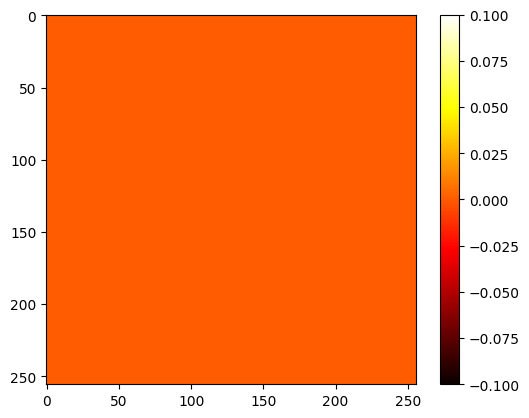

In [9]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from EfficientAD.models import Teacher
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class Inference(object):

    def __init__(self, model_path, model_size='S', device='cuda') -> None:
        self.teacher = Teacher(model_size)
        self.model_path = model_path
        self.device = device
        self.load_model()
        self.data_transforms = transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        ])

    def load_model(self):
        teacher_ckpt = torch.load(self.model_path+'/best_teacher.pth', map_location=torch.device(self.device))
        self.teacher.load_state_dict(teacher_ckpt)
        self.teacher.eval()
        self.teacher.to(self.device)

    def extract_features(self, img):
        img = self.data_transforms(img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            teacher_output = self.teacher(img)
        return teacher_output

    def normalize_features(self, features):
        channel_mean = features.mean(dim=(2, 3), keepdim=True)
        channel_std = features.std(dim=(2, 3), keepdim=True)
        normalized_features = (features - channel_mean) / channel_std
        return normalized_features

    def compare_images(self, img1, img2):
        features1 = self.extract_features(img1)
        features2 = self.extract_features(img2)
        
        # Normalize the features
        normalized_features1 = self.normalize_features(features1)
        normalized_features2 = self.normalize_features(features2)
        
        distance = torch.pow(normalized_features1 - normalized_features2, 2)
        fmap = torch.mean(distance, dim=1, keepdim=True)
        fmap = F.interpolate(fmap, size=(256, 256), mode='bilinear')
        return fmap

if __name__ == "__main__":
    model_path = '/mnt/data_hdd3/zby/opencv/EfficientAD/ckptSmall'
    infer = Inference(model_path, model_size='S', device='cuda')
    
    # Load two images
    img1 = Image.open('/mnt/data_hdd3/zby/bus.jpg')
    img2 = Image.open('/mnt/data_hdd3/zby/bus.jpg')

    # Compare the two images
    difference_map = infer.compare_images(img1, img2)

    # Visualize the difference map
    difference_map_np = difference_map[0, 0, :, :].cpu().detach().numpy()
    plt.imshow(difference_map_np, cmap='hot')
    plt.colorbar()
    plt.show()


# LBP

In [12]:
import os
import cv2
import numpy as np
import time
import glob
from skimage.feature import local_binary_pattern

def calculate_lbp(image, P=8, R=1):
    """计算图像的LBP特征"""
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), range=(0, P + 2))
    return hist / hist.sum()

def compare_histograms(hist1, hist2, method=cv2.HISTCMP_CHISQR):
    """比较两个直方图"""
    hist1 = hist1.astype('float32')
    hist2 = hist2.astype('float32')
    return cv2.compareHist(hist1, hist2, method)

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask=fg_mask
        return motion_mask

    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask, image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    color_foreground = cv2.cvtColor(color_foreground, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cumulative_histogram = np.zeros(10)
    hists = []

    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = color_foreground[y:y+h, x:x+w]
        
        # 计算裁剪区域的LBP直方图
        histogram = calculate_lbp(cropped_region)
        hists.append(histogram)
        
        # 累加到综合直方图中
        cumulative_histogram += histogram

    return cumulative_histogram, hists

def main():
    sub_type = 'MOG2' # 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True, history=800)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path = '/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num = 20
    frame_count = 0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start = time.time()
    cap = cv2.VideoCapture(video)
    while(1):
        if frame_count > 100:
            break
        ret, image = cap.read()
        frame_count += 1
        fg_mask = backSub.apply(image)
    frame_count = 0
    hists = []
    count = []
    min_frames = []
    max_frames = []
    count = [0] * query_num
    for i in range(query_num):
        img = cv2.imread(query_inputs[i], cv2.IMREAD_GRAYSCALE)
        histogram = calculate_lbp(img)
        hists.append(histogram)
        query_frame = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min_frames.append(query_frame - frame_len // 2)
        max_frames.append(query_frame + frame_len // 2)
    print("get base bg time:")
    print(time.time() - start)
    gen_bg = 0
    his_time = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall = [0] * query_num

    while True:
        start = time.time()
        ret, image = cap.read()
        if not ret:
            break
        frame_count += 1
        fg_mask = backSub.apply(image)
        gen_bg += time.time() - start
        
        start = time.time()
        try:
            cumulative_histogram, histss = calculate(fg_mask, image)
        except Exception as e:
            print(frame_count)
            continue
        his_time += time.time() - start
        
        for i in range(query_num):
            similarity = compare_histograms(cumulative_histogram, hists[i])
            similarity_min = similarity
            for j in range(len(histss)):
                similarity_t = compare_histograms(histss[j], hists[i])
                if similarity_min > similarity_t:
                    similarity_min = similarity_t
            if similarity_min < 0.6:
                count[i] += 1
                if min_frames[i] < frame_count < max_frames[i]:
                    recall[i] += 1
                    
    print(count)
    for i in range(query_num):
        re = recall[i] / (max_frames[i] - min_frames[i])
        print(query_inputs[i])
        print(re)
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    
if __name__ == "__main__":
    main()


get base bg time:
0.5679500102996826
[57164, 57232, 81707, 55932, 57954, 55694, 70072, 51605, 56395, 55910, 76636, 51774, 59236, 56215, 55134, 57453, 57206, 52812, 62569, 60826]
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_138_968_59202.jpg
0.8985507246376812
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_188_1357_79389.jpg
0.9414893617021277
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_192_1782_100433-5.jpg
0.9947916666666666
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_288_551_33425.jpg
0.2638888888888889
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_106_1809_102111-2.jpg
0.8113207547169812
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1336_77929-2.jpg
0.8333333333333334
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_132_1950_104765.jpg
0.5
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_tes

# mobilenet

In [5]:
import os
import cv2
import numpy as np
import time
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
from PIL import Image

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载预训练的MobileNetV3-Small模型并移到GPU
model = mobilenet_v3_small(weights='IMAGENET1K_V1').to(device)
model.eval()  # 设置模型为评估模式

# 移除最后的分类层
model = torch.nn.Sequential(*list(model.children())[:-1])

# 图像预处理
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def process_images(image_paths):
    input_tensors = []
    for image_path in image_paths:
        img = Image.open(image_path)
        input_tensor = preprocess(img)
        input_tensor = input_tensor.unsqueeze(0)  # 添加批次维度
        input_tensors.append(input_tensor)
    input_tensors = torch.cat(input_tensors, dim=0)  # 合并成一个批次
    input_tensors = input_tensors.to(device)  # 将输入张量移到GPU
    return input_tensors

def extract_features(input_tensor, model):
    """提取特征向量并确保长度一致"""
    with torch.no_grad():
        features = model(input_tensor)
    features = features.squeeze().cpu().numpy()
    return features

def compare_features(feat1, feat2, method='euclidean'):
    """比较两个特征向量"""
    if method == 'euclidean':
        return np.linalg.norm(feat1 - feat2)
    else:
        raise ValueError("Unsupported comparison method")

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """Obtains image mask"""
    _, thresh = cv2.threshold(fg_mask, min_thresh, 255, cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask = fg_mask
        return motion_mask
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask, image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_len = 1280  # 设定特征向量长度
    cumulative_features = np.zeros(max_len)
    features_list = []

    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = image[y:y+h, x:x+w]
        img_pil = Image.fromarray(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
        input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

        # 计算裁剪区域的特征
        features = extract_features(input_tensor, model)
        if features.size < max_len:
            features = np.pad(features, (0, max_len - features.size), 'constant')
        else:
            features = features[:max_len]
        features_list.append(features)
        
        # 累加到综合特征中
        cumulative_features += features

    return cumulative_features, features_list

def main():
    sub_type = 'MOG2' # 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True, history=800)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path = '/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num = 20
    frame_count = 0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start = time.time()
    cap = cv2.VideoCapture(video)
    while(1):
        if frame_count > 100:
            break
        ret, image = cap.read()
        frame_count += 1
        fg_mask = backSub.apply(image)
    frame_count = 0
    features_list = []
    count = []
    min_frames = []
    max_frames = []
    count = [0] * query_num
    max_len = 1280  # 设定特征向量长度
    for i in range(query_num):
        img = cv2.imread(query_inputs[i])
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
        features = extract_features(input_tensor, model)
        if features.size < max_len:
            features = np.pad(features, (0, max_len - features.size), 'constant')
        else:
            features = features[:max_len]
        features_list.append(features)
        query_frame = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min_frames.append(query_frame - frame_len // 2)
        max_frames.append(query_frame + frame_len // 2)
    print("get base bg time:")
    print(time.time() - start)
    gen_bg = 0
    his_time = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall = [0] * query_num

    total_inference_time = 0
    inference_count = 0

    while True:
        start = time.time()
        ret, image = cap.read()
        if not ret:
            break
        frame_count += 1
        fg_mask = backSub.apply(image)
        gen_bg += time.time() - start
        
        start = time.time()
        try:
            cumulative_features, features_lists = calculate(fg_mask, image)
        except Exception as e:
            print(frame_count)
            continue
        his_time += time.time() - start
        
        for i in range(query_num):
            similarity = compare_features(cumulative_features, features_list[i])
            similarity_min = similarity
            for j in range(len(features_lists)):
                similarity_t = compare_features(features_lists[j], features_list[i])
                if similarity_min > similarity_t:
                    similarity_min = similarity_t
            if similarity_min < 10:
                count[i] += 1
                if min_frames[i] < frame_count < max_frames[i]:
                    recall[i] += 1

        # 计算并累加每次推理时间
        inference_time = time.time() - start
        total_inference_time += inference_time
        inference_count += 1

    # 计算平均推理时间
    average_inference_time = total_inference_time / inference_count if inference_count > 0 else 0

    print(count)
    for i in range(query_num):
        re = recall[i] / (max_frames[i] - min_frames[i])
        print(query_inputs[i])
        print(re)
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    print(f"Average Inference Time: {average_inference_time} seconds")
    
if __name__ == "__main__":
    main()


/home/zby/anaconda3/envs/efficient/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


get base bg time:
2.751793384552002
[60105, 100093, 71106, 11155, 95088, 30098, 59670, 90097, 98860, 89736, 6259, 94072, 35074, 98237, 94173, 25970, 53958, 84445, 5123, 85344]
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_138_968_59202.jpg
0.8623188405797102
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_188_1357_79389.jpg
0.9893617021276596
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_192_1782_100433-5.jpg
0.9791666666666666
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_288_551_33425.jpg
0.3715277777777778
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_106_1809_102111-2.jpg
0.9905660377358491
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_7_1336_77929-2.jpg
0.6666666666666666
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test/taipei_test_132_1950_104765.jpg
0.9393939393939394
/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_te

# squeezenet

In [14]:
import os
import cv2
import numpy as np
import time
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
from PIL import Image

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载预训练的EfficientNet-B0模型并移到GPU
model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
model.eval()  # 设置模型为评估模式

# 定义提取特征的方法
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(EfficientNetFeatureExtractor, self).__init__()
        self.model = model

    def forward(self, x):
        x = self.model.extract_features(x)
        x = torch.flatten(x, 1)
        return x

feature_extractor = EfficientNetFeatureExtractor(model).to(device)
feature_extractor.eval()

# 图像预处理
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def process_images(image_paths):
    input_tensors = []
    for image_path in image_paths:
        img = Image.open(image_path)
        input_tensor = preprocess(img)
        input_tensor = input_tensor.unsqueeze(0)  # 添加批次维度
        input_tensors.append(input_tensor)
    input_tensors = torch.cat(input_tensors, dim=0)  # 合并成一个批次
    input_tensors = input_tensors.to(device)  # 将输入张量移到GPU
    return input_tensors

def extract_features(input_tensor, model):
    """提取特征向量并确保长度一致"""
    with torch.no_grad():
        features = model(input_tensor)
    features = features.cpu().numpy()  # 转换为numpy数组
    return features

def compare_features(feat1, feat2, method='euclidean'):
    """比较两个特征向量"""
    if method == 'euclidean':
        return np.linalg.norm(feat1 - feat2)
    else:
        raise ValueError("Unsupported comparison method")

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """Obtains image mask"""
    _, thresh = cv2.threshold(fg_mask, min_thresh, 255, cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask = fg_mask
        return motion_mask
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def calculate(fg_mask, image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.array((9,9), dtype=np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_len = 1280  # 设定特征向量长度
    cumulative_features = np.zeros(max_len)
    features_list = []

    for contour in contours:
        if cv2.contourArea(contour) > 800:  # 过滤掉小面积的轮廓
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = image[y:y+h, x:x+w]
        img_pil = Image.fromarray(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
        input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

        # 计算裁剪区域的特征
        features = extract_features(input_tensor, feature_extractor)
        features = features.flatten()  # 展平特征向量
        if features.size < max_len:
            features = np.pad(features, (0, max_len - features.size), 'constant')
        else:
            features = features[:max_len]
        features_list.append(features)
        
        # 累加到综合特征中
        cumulative_features += features

    return cumulative_features, features_list

def main():
    sub_type = 'MOG2' # 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True, history=800)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path = '/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num = 20
    frame_count = 0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start = time.time()
    cap = cv2.VideoCapture(video)
    while(1):
        if frame_count > 100:
            break
        ret, image = cap.read()
        frame_count += 1
        fg_mask = backSub.apply(image)
    frame_count = 0
    features_list = []
    count = []
    min_frames = []
    max_frames = []
    count = [0] * query_num
    max_len = 1280  # 设定特征向量长度
    for i in range(query_num):
        img = cv2.imread(query_inputs[i])
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
        features = extract_features(input_tensor, feature_extractor)
        features = features.flatten()  # 展平特征向量
        if features.size < max_len:
            features = np.pad(features, (0, max_len - features.size), 'constant')
        else:
            features = features[:max_len]
        features_list.append(features)
        query_frame = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-1].split('-')[0])
        frame_len = int(os.path.basename(query_inputs[i]).split('.')[0].split('_')[-3])
        min_frames.append(query_frame - frame_len // 2)
        max_frames.append(query_frame + frame_len // 2)
    print("get base bg time:")
    print(time.time() - start)
    gen_bg = 0
    his_time = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall = [0] * query_num

    total_inference_time = 0
    inference_count = 0

    while True:
        start = time.time()
        ret, image = cap.read()
        if not ret:
            break
        frame_count += 1
        fg_mask = backSub.apply(image)
        gen_bg += time.time() - start
        
        start = time.time()
        try:
            cumulative_features, features_lists = calculate(fg_mask, image)
        except Exception as e:
            print(frame_count)
            continue
        his_time += time.time() - start
        
        for i in range(query_num):
            similarity = compare_features(cumulative_features, features_list[i])
            similarity_min = similarity
            for j in range(len(features_lists)):
                similarity_t = compare_features(features_lists[j], features_list[i])
                if similarity_min > similarity_t:
                    similarity_min = similarity_t
            if similarity_min < 10:
                count[i] += 1
                if min_frames[i] < frame_count < max_frames[i]:
                    print(similarity_min)
                    recall[i] += 1
        
        # 计算并累加每次推理时间
        inference_time = time.time() - start
        total_inference_time += inference_time
        inference_count += 1

    # 计算平均推理时间
    average_inference_time = total_inference_time / inference_count if inference_count > 0 else 0

    print(count)
    for i in range(query_num):
        re = recall[i] / (max_frames[i] - min_frames[i])
        print(query_inputs[i])
        print(re)
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    print(f"Average Inference Time: {average_inference_time} seconds")
    
if __name__ == "__main__":
    main()


Loaded pretrained weights for efficientnet-b0
get base bg time:
0.8682913780212402


KeyboardInterrupt: 

# sift+hog

In [3]:
import os
import cv2
import numpy as np
import time
import glob
from skimage.feature import hog as skimage_hog
from skimage import color

def calculate_sift(image):
    """计算图像的SIFT特征"""
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def calculate_hog_cv2(image):
    """使用cv2计算图像的HOG特征"""
    hog_descriptor = cv2.HOGDescriptor()
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 将图像转换为灰度图
    image = cv2.resize(image, (64, 128))  # 调整图像尺寸以符合HOGDescriptor的要求
    return hog_descriptor.compute(image)

def calculate_hog_skimage(image):
    """使用skimage计算图像的HOG特征"""
    image = color.rgb2gray(image)
    h, _ = skimage_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=False)
    return h

def get_motion_mask(fg_mask, min_thresh=0, kernel=np.ones((9, 9), np.uint8)):
    """获取运动掩码"""
    _, thresh = cv2.threshold(fg_mask, min_thresh, 255, cv2.THRESH_BINARY)
    if thresh is not None and thresh.size > 0:
        motion_mask = cv2.medianBlur(thresh, 3)
    else:
        motion_mask = fg_mask
        return motion_mask
    
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return motion_mask

def calculate(fg_mask, image):
    motion_mask = get_motion_mask(fg_mask, kernel=np.ones((9, 9), np.uint8))
    color_foreground = cv2.bitwise_and(image, image, mask=motion_mask)
    color_foreground = cv2.cvtColor(color_foreground, cv2.COLOR_BGR2RGB)
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    sift_features = []
    hog_features = []
    keypoints_all = []
    
    for contour in contours:
        if cv2.contourArea(contour) > 800:
            x, y, w, h = cv2.boundingRect(contour)
        else:
            continue
        cropped_region = image[y:y+h, x:x+w]
        
        keypoints, descriptors = calculate_sift(cropped_region)
        sift_features.append(descriptors)
        keypoints_all.append(keypoints)
        
        hog_feature = calculate_hog_cv2(cropped_region)
        hog_features.append(hog_feature)
    
    return sift_features, hog_features, keypoints_all

def main():
    sub_type = 'MOG2'
    if sub_type == "MOG2":
        backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=12, detectShadows=True, history=800)
    else:
        backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=800, detectShadows=True)

    folder_path = '/mnt/data_hdd1/zby/jackson_town/datasets/query_taipei_test'
    query_inputs = glob.glob(folder_path + "/*")
    query_num = 20
    frame_count = 0
    video = '/home/zby/sigmod/video/taipei_640.mp4'
    start = time.time()
    cap = cv2.VideoCapture(video)
    
    query_sift_features = []
    query_hog_features = []
    
    for query in query_inputs:
        image = cv2.imread(query)
        if image is None:
            continue
        _, descriptors = calculate_sift(image)
        query_sift_features.append(descriptors)
        hog_feature = calculate_hog_cv2(image)
        query_hog_features.append(hog_feature)
    
    print("get base bg time:")
    print(time.time() - start)
    
    gen_bg = 0
    his_time = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    recall = [0] * query_num
    
    while(1):
        start = time.time()
        ret, image = cap.read()
        if not ret:
            break
        frame_count += 1
        fg_mask = backSub.apply(image)
        gen_bg += time.time() - start
        
        start = time.time()
        try:
            sift_features, hog_features, _ = calculate(fg_mask, image)
        except Exception as e:
            print(frame_count)
            continue
        his_time += time.time() - start
        
        for i in range(query_num):
            sift_similarity = 0
            hog_similarity = 0
            for sift_feature in sift_features:
                sift_similarity = max(sift_similarity, compare_sift(sift_feature, query_sift_features[i]))
            for hog_feature in hog_features:
                hog_similarity = max(hog_similarity, compare_hog(hog_feature, query_hog_features[i]))
            
            if sift_similarity > 10 and hog_similarity > 0.7:  # 设定合适的阈值
                recall[i] += 1
    
    print(recall)
    print("fore_bg:")
    print(gen_bg)
    print("calculate:")
    print(his_time)
    
if __name__ == "__main__":
    main()


get base bg time:
0.8620171546936035


KeyboardInterrupt: 